# The topic of my project is visualizing the fate of Sun-like stars in M31 throughout the course of the merger

# Question I'm answering: How can I center a visualization of the merger on the Milky Way (ANSWERED) What criteria should I use to select solar analogs? How do I differentiate the solar analogs from other disk particles?



# Plot to make
# a) Plot of all 3 galaxies centered on the MW (x: Position (kpc), y: Position (kpc), disk particles, all snapshots; visualize merger from MW perspective -> highlights fate of solar analogs in context of merger) COMPLETED

# b) Like plot above, but with solar analogs color-coated

# c) Histogram of solar analog distance from center of M31 (x: Distance (kpc), y: Number of analogs, solar analogs from disk particles, test with first snapshot and some snapshot after pass-by; quantitatively describe fate of Sun-like stars in M31 -> shows distribution as time passes)


In [8]:
# ASTR 400B Project

# Import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# Import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# My modules
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from MassProfile import MassProfile
from OrbitCOM import VectorDiff

In [54]:
# Class for determining fate of a galaxy's solar analogs
class Fate:
    
    # Initialize the instance of this Class with the following properties:
    def __init__(self, galaxy, ptype=2):
        
        # Define galaxy name
        self.galaxy = galaxy
        
        # Define filename of first snapshot (choose candidates at 3 Gyr/snapshot 212)
        self.file1 = 'C:/Users/Jimmy/Downloads/{0}/{0}_212.txt'.format(self.galaxy)
        
        # Define filenames for/extract data from MW and M31 Orbit COM text files
        self.MWCOM_file = 'C:/Users/Jimmy/400B_Lilly/Research Assignments/5/Orbit_MW.txt'
        self.dataMWCOM = np.genfromtxt(self.MWCOM_file,dtype=None,names=True)
        self.M31COM_file = 'C:/Users/Jimmy/400B_Lilly/Research Assignments/5/Orbit_M31.txt'
        self.dataM31COM = np.genfromtxt(self.M31COM_file,dtype=None,names=True)
        
        # Define distance and v_lsr of Sun w.r.t to center of the MW
        self.r = 8.178 # r: Distance of Sun from center of the MW (currently 8.178 kpc from GRAVITY collaboration)
        self.v = 239 # v: Local Standard of Rest velocity of Sun (currently 239 km/s from van der marel+ 2012b)          
        
        # Define CoM object for galaxy using disk particles
        self.COMD1 = CenterOfMass(self.file1,2)

        # Find CoM components for position and velocity of galaxy
        self.COMP1 = self.COMD1.COM_P(0.1,2)
        self.COMV1 = self.COMD1.COM_V(self.COMP1[0],self.COMP1[1],self.COMP1[2])

        # Adjust disk particle positions w.r.t. CoM of host galaxy
        self.xD_1 = self.COMD1.x - self.COMP1[0].value
        self.yD_1 = self.COMD1.y - self.COMP1[1].value
        self.zD_1 = self.COMD1.z - self.COMP1[2].value

        # Adjust disk particle velocities w.r.t. CoM of host galaxy
        self.vxD_1 = self.COMD1.vx - self.COMV1[0].value
        self.vyD_1 = self.COMD1.vy - self.COMV1[1].value
        self.vzD_1 = self.COMD1.vz - self.COMV1[2].value

        # Calculate disk particle distances to center of host galaxy
        self.R = np.sqrt(self.xD_1**2+self.yD_1**2+self.zD_1**2)

        # Calculate in-plane velocity and assign out-of-plane velocities
        self.Vc = np.sqrt(self.vxD_1**2+self.vyD_1**2)
        self.Vz = self.vzD_1

        # Select particles within 10% of Sun's distance and circular velocity (also w/ Vz < 30 km/s)
        self.candidates = np.where((self.R <= 1.1*self.r) & (self.R >= 0.9*self.r) & (self.Vc <= 1.1*self.v) & (self.Vc >= 0.9*self.v) & (np.abs(self.Vz) < 30))
        
    # Function to identify solar analogs
    # Should be run only called once at end of code --> candidates will have same indices throughout simulation
    def FirstLook(self):
        # Extract relative separation and velocity of MW and M31 throughout simulation
        time, MW_M31_diffP, MW_M31_diffV = VectorDiff(self.dataMWCOM,self.dataM31COM)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

        # Identify solar analogs
        r_analogs = self.R[self.candidates]
        
        # Plot histogram of candidate distances from center of galaxy
        # Overplot vertical lineof current position of Sun in the MW (from GRAVITY collaboration)
        ax1.axvline(x=self.r,color='red',linestyle='dashed')
        ax1.hist(r_analogs)

        # Add axis labels and title to first subplot
        ax1.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
        ax1.set_xlabel('Distance from Center of {} (kpc)'.format(self.galaxy), fontsize=18)
        ax1.set_ylabel('Number of Candidates', fontsize=18)
        ax1.set_xlim(.9*self.r-.5,1.1*self.r+.5)
        
        partIn = len(r_analogs[r_analogs<self.r])
        partOut = len(r_analogs[r_analogs>self.r])
        PercentIn = np.around((partIn/len(r_analogs))*100,2)
        PercentOut = np.around((partOut/len(r_analogs))*100,2)
        
        stats = ('{0} Gyr from now'+'\n'+'% In = {1}'+'\n'+'% Out = {2}').format(time[212],PercentIn,PercentOut)
        
        ax1.annotate(stats,xy=(.35,.8),xycoords='axes fraction',bbox=dict(boxstyle="round",fc="0.8"),fontsize = 12)
        
        # Plot all disk particles
        h = ax2.hist2d(self.xD_1,self.yD_1,bins=200,norm=LogNorm(),cmap='viridis')

        # Plot colorbar of disk density
        cbar = plt.colorbar(h[3],ax=ax2)
        cbar.ax.set_ylabel('Number of Particles', fontsize=18)

        # Highlight solar analogs within disk
        ax2.scatter(self.xD_1[self.candidates],self.yD_1[self.candidates],color='red',s=5)

        # Add axs labels and title to second subplot
        ax2.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
        ax2.set_xlabel('x (kpc)', fontsize=18)
        ax2.set_ylabel('y (kpc)', fontsize=18)

        # Adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        # Create buffer space between subplots
        plt.tight_layout()

        # Save plot of initial solar analogs (uncomment when need to change)
        plt.savefig("C:/Users/Jimmy/400B_Lilly/Research Assignments/5/M31_candidates.png")
        
    # Plot later visualizations of solar candidates
    def Tracking(self,start,end,increment):

        #  Define range of snapshots to use (first, last, how frequently to choose another snapshot)
        snap_ids = np.arange(start,end,increment)
        
        for i, snap_id in enumerate(snap_ids):
        
            # Compose the data filename (be careful about the folder)
            # Add string of filenumber to value 000
            ilbl = '000' + str(snap_id)

            # Remove all but last 3 digits of string
            ilbl = ilbl[-3:]

            # Assign filename based on snapshot and galaxy inputs
            MW_file = 'C:/Users/Jimmy/Downloads/MW/MW_' + ilbl + '.txt'
            M31_file = 'C:/Users/Jimmy/Downloads/M31/M31_' + ilbl + '.txt'
            M33_file = 'C:/Users/Jimmy/Downloads/M33/M33_' + ilbl + '.txt'

            # Define CoM object for each galaxy using disk particles (2)
            COMD_MW = CenterOfMass(MW_file,2)
            COMD_M31 = CenterOfMass(M31_file,2)
            COMD_M33 = CenterOfMass(M33_file,2)

            # Find CoM components for position and velocity of the MW
            COMP_MW = COMD_MW.COM_P(0.1,2)
            COMV_MW = COMD_MW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])

            # Define positions of the MW's Disk Particles w.r.t the MW
            xD_MW = COMD_MW.x - COMP_MW[0].value
            yD_MW = COMD_MW.y - COMP_MW[1].value
            zD_MW = COMD_MW.z - COMP_MW[2].value

            # Define positions of M31 Disk Particles w.r.t the MW
            xD_M31 = COMD_M31.x - COMP_MW[0].value
            yD_M31 = COMD_M31.y - COMP_MW[1].value
            zD_M31 = COMD_M31.z - COMP_MW[2].value
            
            # Define positions of M33 Disk Particles
            xD_M33 = COMD_M33.x - COMP_MW[0].value
            yD_M33 = COMD_M33.y - COMP_MW[1].value
            zD_M33 = COMD_M33.z - COMP_MW[2].value
            
            # Extract relative separation and velocity of MW and M31 throughout simulation
            time, MW_M31_diffP, MW_M31_diffV = VectorDiff(self.dataMWCOM,self.dataM31COM)
            
            # Define distance of disk particles from center of respective galaxy
            if self.galaxy == 'M31':
                COMP_M31 = COMD_M31.COM_P(0.1,2)
                x = COMD_M31.x - COMP_M31[0].value
                y = COMD_M31.y - COMP_M31[1].value
                z = COMD_M31.z - COMP_M31[2].value
            elif self.galaxy == 'M33':
                COMP_M33 = COMD_M31.COM_P(0.1,2)
                x = COMD_M33.x - COMP_M33[0].value
                y = COMD_M33.y - COMP_M33[1].value
                z = COMD_M33.z - COMP_M33[2].value
            elif self.galaxy == 'MW':
                COMP_MW = COMD_MW.COM_P(0.1,2)
                x = COMD_MW.x - COMP_MW[0].value
                y = COMD_MW.y - COMP_MW[1].value
                z = COMD_MW.z - COMP_MW[2].value
            
            # Define distance of disk particles from center of galaxy of interest
            R = np.sqrt(x**2+y**2+z**2)
            r_analogs = R[self.candidates]
            
            # Calculate percentage of Sun-like stars in M31 that are beyond and within the current Sun distance
            partIn = len(r_analogs[r_analogs<self.r])
            partOut = len(r_analogs[r_analogs>self.r])
            PercentIn = np.around((partIn/len(r_analogs))*100,2)
            PercentOut = np.around((partOut/len(r_analogs))*100,2)
            stats = ('{0} Gyr from now'+'\n'+'% In = {1}'+'\n'+'% Out = {2}').format(time[snap_id],PercentIn,PercentOut)
            
            # Create subplots
            fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

            # Plot histogram of candidate distances from center of galaxy
            # Overplot vertical lineof current position of Sun in the MW (from GRAVITY collaboration)
            ax1.axvline(x=self.r,color='red',linestyle='dashed')
            ax1.hist(r_analogs,bins=20)

            # Add axes labels and titles to first subplot
            ax1.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
            ax1.set_xlabel('Distance from Center of {} (kpc)'.format(self.galaxy), fontsize=18)
            ax1.set_ylabel('Number of Candidates', fontsize=18)
            ax1.annotate(stats,xy=(.35,.8),xycoords='axes fraction',bbox=dict(boxstyle="round",fc="0.8"),fontsize = 12)
            
            # Plot all disk particles
            h1 = ax2.hist2d(xD_MW,yD_MW,bins=200,norm=LogNorm(),cmap='viridis')
            h2 = ax2.hist2d(xD_M31,yD_M31,bins=200,norm=LogNorm(),cmap='viridis')
            h3 = ax2.hist2d(xD_M33,yD_M33,bins=200,norm=LogNorm(),cmap='viridis')
            
            # Plot colorbar of disk density
            cbar = plt.colorbar(h1[3],ax=ax2)
            cbar.ax.set_ylabel('Number of Particles', fontsize=18)

            # Highlight solar analogs within disk as points
            ax2.scatter(xD_M31[self.candidates],yD_M31[self.candidates],color='red',s=1)

            # Add axes labels and titles to second subplot
            ax2.set_title('LG in {0} Gyr'.format(time[snap_id]), fontsize=22)
            ax2.set_xlabel('x (kpc)', fontsize=18)
            ax2.set_ylabel('y (kpc)', fontsize=18)
            
            # Set axis limits
            plt.xlim(-500,250)
            plt.ylim(-200,500)

            # Adjust tick label font size
            label_size = 22
            matplotlib.rcParams['xtick.labelsize'] = label_size 
            matplotlib.rcParams['ytick.labelsize'] = label_size

            # Create buffer space between subplots
            plt.tight_layout()
            
            # Save image to a file
            plt.savefig('C:/Users/Jimmy/400B_Lilly/Research Assignments/5/Merger_{0}_{1}.png'.format(self.galaxy,ilbl), rasterized=True, dpi=100)
            #plt.savefig('C:/Users/Jimmy/Downloads/Simulation4/{0}/Simulation4_{0}_{1}.png'.format(self.galaxy,ilbl), rasterized=True, dpi=100)


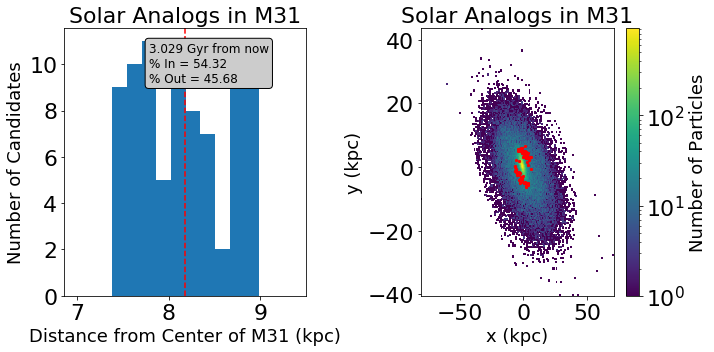

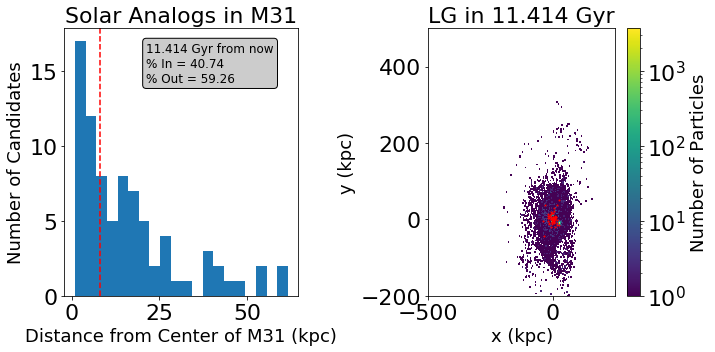

In [55]:
M31 = Fate('M31')
M31.FirstLook()
M31.Tracking(799,800,1)